In [1512]:
import torch
torch.pi = torch.acos(torch.zeros(1)).item() * 2
import torch.nn as nn
import torch.nn.functional as F

import math

from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2092]:
class TensorToPolygon:
    
    def __call__(self, data):
        data = data.view(-1, 784)
        data = list(data.unbind())
        data = [torch.arange(784)[(x > 0.8)] for x in data]
        data = [torch.Tensor(list(x) + (351 - len(x)) * [0]) for x in data]
        data = torch.stack(data).contiguous()
        return data
    
    
class OneDToTwoD:
    
    def __call__(self, data):
        
        data = [torch.Tensor(x[x != 0]) for x in data]   
        data = [torch.Tensor([list([b // 28, b % 28]) for b in a]) for a in data]
        data = [torch.cat((x, torch.Tensor(np.zeros((351 - x.shape[0],2))))) for x in data]
        data = torch.stack(data).contiguous()
        return data
    
class Transform1d2d:
    def __call__(self, x):
        return torch.stack([x // 28, x % 28], -1)
    
#class Transform1d2d:
#    def __call__(self, x):
#        return torch.stack([((x // 28) -14) * (x != 0), ((x % 28) - 14) * (x != 0)], -1)
        

In [2093]:
def plot_preprocessing(xy):
    matrix = np.zeros(784)

    for x, y in xy[0]:
        #x = int(x)+14
        #y = int(y)+14
        x = int(x)
        y = int(y)
        index = int(x*28+y)
        matrix[index] = 1
        
    img_size = int(math.sqrt(784))
    return np.reshape(matrix, (img_size, img_size))

def plot_preprocessing1(xy):
    matrix = np.zeros(784)

    for x, y in xy[0]:
        x = int(x+14)
        y = int(y+14)
        #x = int(x)
        #y = int(y)
        index = int(x*28+y)
        if index < 784:
            matrix[index] = 1
        
    img_size = int(math.sqrt(784))
    return np.reshape(matrix, (img_size, img_size))

#plt.imshow(plot_preprocessing(default))
#print(c_mass(default)[:,0])

In [2094]:
math.sqrt(784)

28.0

In [2444]:
dataset1 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=0, translate=None, scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
                          ]))

dataset2 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=180, translate=None, scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
                          ]))

dataset3 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=0, translate=(0.2,0.2), scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
                          ]))

dataset4 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=0, translate=None, scale=(0.8,1.2)),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
                          ]))

In [2549]:
default = dataset1[0][0]
rotated = dataset2[0][0]
translated = dataset3[0][0]
scaled = dataset4[0][0]

2
a: tensor([3.5565])


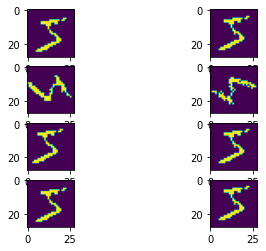

In [2554]:
figure, axis = plt.subplots(4, 2)

axis[0, 0].imshow(plot_preprocessing(default))
axis[0, 1].imshow(plot_preprocessing1(canonical_transformation(default, default)))

axis[1, 0].imshow(plot_preprocessing(rotated))
axis[1, 1].imshow(plot_preprocessing1(canonical_transformation(rotated, default)))

axis[2, 0].imshow(plot_preprocessing(translated))
axis[2, 1].imshow(plot_preprocessing1(canonical_transformation(translated, default)))

axis[3, 0].imshow(plot_preprocessing(scaled))
axis[3, 1].imshow(plot_preprocessing1(canonical_transformation(scaled, default)))

In [2527]:
def moment(xy, p, q):
    x = xy[:, :, 0]
    y = xy[:, :, 1]
    x = x.pow(p) * (x != 0)
    y = y.pow(q) * (y != 0)
    M = (x * y).sum(-1)
    return M
    

def c_mass(xy):
    mass = moment(xy, 0, 0)
    mx = moment(xy, 1, 0) / mass
    my = moment(xy, 0, 1) / mass
    return torch.stack([mx, my], -1)

def mu(xy, p, q):
    m = c_mass(xy)
    x = xy[:, :, 0]
    y = xy[:, :, 1]
    x = (x - m[:, 0]).pow(p) * (x != 0)
    y = (y - m[:, 1]).pow(q) * (y != 0)
    M = (x * y).sum(-1)
    return M

def nu(xy, p, q):
    return mu(xy, p, q) / (mu(xy,0,0)**(1 + (p+q)/2))

In [2553]:
def scale_factor(scaled, original):
    return torch.sqrt(mu(scaled,0,0) / mu(original,0,0))

def normalized_cgm(scaled, p, q):
    w = (p+q)/2+1
    return mu(scaled,p,q) / mu(scaled,0,0)**w

def rotation_alpha2(q, p, r):
    #r = mu'11
    #q = mu11
    #p = (mu20 - mu02)
    return (2 * (p*r - torch.sqrt(p.pow(2)*q.pow(2) + 4*q.pow(4) - 4*q.pow(2)*r.pow(2)))) / (p.pow(2) + 4*q.pow(2))
    

def canonical_transformation(xy, original):
#   translation
    m = c_mass(xy)
    x = xy - m.view(1, 1, 2) * (xy[:, :, 0] != 0).view(1, -1, 1)
#   scale
    scale = scale_factor(xy, original)
    x = x / scale
    
    
#   rotation

    r = mu(xy,1,1)
    q = mu(original,1,1)
    if (q-r) != 0:
        p = mu(original,2,0) - mu(original,0,2)
        
        if (r > (q*-1)) == True:
            a = (torch.pi - 0.5*torch.arcsin(rotation_alpha2(q, p, r)))
            
            print(1)
        else: 
            a = 0.5*torch.arcsin(rotation_alpha2(q, p, r))
            print(2)
            
        a = a = (torch.pi - 0.5*torch.arcsin(rotation_alpha2(q, p, r)))
        #a = rotation_alpha(q, p, r)
        print("a: " + str(a))
        if torch.isnan(a) == False:
    
            x1 = (x[:, :, 0]*torch.cos(a) - x[:, :, 1]*torch.sin(a))
            x2 = (x[:, :, 0]*torch.sin(a) + x[:, :, 1]*torch.cos(a))
        
            x = torch.stack([x1,x2], -1)
    
    return x

#rotated = dataset2[0][0]
#translated = dataset3[0][0]
#scaled = dataset4[0][0]

#print(default[:,:10])

#canonical_transformation(default, default)
#canonical_transformation(rotated, default)
#print(scaled[:,:10])

In [2480]:
#rotated = dataset2[0][0]
#print(mu(rotated,1,1))
##print(mu(default,2,0))
#print(mu(default,0,2))
#print(mu(default,1,1))

r = mu(rotated,1,1)
q = mu(default,1,1)
p = mu(default,2,0) - mu(default,0,2)

print(r)
print(q)
print(p)

rotation_alpha(q, p, r)

tensor([721.1772])
tensor([-721.1772])
tensor([-2228.7344])


tensor([-2.5672])

##### $$
\mathbf{M} = \frac{\sum_i \mathbf{r_i} * m_i}{\sum_i m_i}
$$

$$
\mathbf{M}' = \frac{\sum_i [\mathbf{r_i} + \pmb{\delta}] * m_i}{\sum_i m_i}
= \frac{\sum_i \mathbf{r_i}* m_i}{\sum_i m_i} + \frac{\sum_i \pmb{\delta}* m_i}{\sum_i m_i}
= \mathbf{M} + \pmb{\delta}
$$

In [2297]:
torch.arcsin(torch.tensor(1))

tensor(1.5708)

torch.Size([1, 351])